In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import glob

sns.set()
sns.set_style("white")

%matplotlib inline

## Implementation of the full circuit model 

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

'''
Dictionary of network parameters,
Wut, Wuv, Wvt, Wvu: weights of connections
dt: interval of, in ms
tau: time constant, in ms
y0: threshold of SAM
IF: input used for reset
uinit, vinit, yinit: initial state of u, v and y
first_duration: duration of first interval before first flash, in ms
'''
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
              'first_duration': 750}

In [3]:
def dual_process_model_generalized(state_init, params, niter, durations, sigma, K, alpha):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    first_duration = PARAMS_DICT['first_duration']
    nbinfirst = int(first_duration / dt)

    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    durs = np.cumsum(np.divide(durations,dt))
    durs = durs.astype(int)
    
    # Make the first duration constant
    durs += (nbinfirst - durs[0])

    #print(durs)
    
    for i in range(niter): 
        # First flash, no I update
        if i == durs[0]:
            #print(i, 'first flash')
            sig = 1.0
        elif any(i == durs):
            sig = 1.0
            I += (sig * K * (yS - y0)) / tau * dt
            #print(i, 'flash')
        else:
            sig = 0.0
            I += (sig * K * (yS - y0)) / tau * dt
        
        

        # u-v and y update
        uS += (-uS + thresh_exp(Wut * I - Wuv * vS - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - IF * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + IF * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / tau * dt
        
        yPcurr = yP.copy()
        yScurr = yS.copy()
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p, production_lst

In [4]:
def simulate_synchronization(sigma, K, initI, alpha, ntrials=1, durations=[600, 600, 600, 600, 1000, 600, 600]):
    '''
    For simulating the full circuit model
    sigma, K, initI, alpha: free parameters of the model
    ntrials: number of trials for averaging
    durations: a list specifying the ISIs
    '''
    nbin = int(sum(np.divide(durations,PARAMS_DICT['dt'])))
    
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * PARAMS_DICT['uinit'], 
                  np.ones(ntrials) * PARAMS_DICT['vinit'],
                  np.ones(ntrials) * PARAMS_DICT['yinit'],
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = dual_process_model_generalized(state_init, 
                                                                        PARAMS_DICT, nbin, durations, sigma, K, alpha)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, np.array(production_lst) 



## Synchronization-continuation simulation

Here, we try to simulate the synchronization-continuation experiment, and compare the simulation to observed behavioral data.

SyncContData\AL_2_20170719_SynCon_ITIs.mat
SyncContData\ER_2_20170718_SynCon_ITIs.mat
SyncContData\FK_2_20170721_SynCon_ITIs.mat
SyncContData\KL_2_20170721_SynCon_ITIs.mat
SyncContData\MW_2_20170720_SynCon_ITIs.mat
SyncContData\RC_2_20170721_SynCon_ITIs.mat


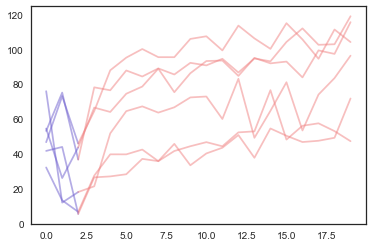

In [5]:
# Load the subjects' behavior 
filename = 'AL1_20180718_syncon_ITIs.mat'
data = scipy.io.loadmat(filename)
durs = data['durs'].flatten()
splits = data['allDur_splits']
IPI_mean = data['allDur_mean']

# Load the processed data
dirlst = glob.glob('SyncContData\\*_2_*ITIs.mat')
plotlst = [0,3,4,5,6,7]
tmax = 20
bias_all_lst = np.zeros((len(plotlst), tmax))
color1 = 'slateblue'
color2 = 'lightcoral'

def find_bias_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_mean = data['allDur_mean'][0]
    
    Bias = np.zeros((tmax, 5))

    for i in range(len(IPI_mean)):
        IPI_single = IPI_mean[i].flatten()[:tmax]
        bias_single = IPI_single - durs[i]
        Bias[:,i] = bias_single
    
    return Bias

# Visualize individual subject bias
for id, i in enumerate(plotlst):
    filename = dirlst[i]
    print(filename)
    bias_arr = find_bias_arr(filename, tmax)
    bias = np.sqrt(np.nanmean(bias_arr**2, axis=1)) * 1000
    
    bias_all_lst[id,:] = bias
    plt.plot(bias[:3], color1, alpha=0.5)
    plt.plot(range(2,20), bias[2:], color2, alpha=0.5)

In [6]:
trials = splits[0,0]
N = trials.shape[0]

# Get number of taps for each trial
ntaps = np.sum(~np.isnan(trials), axis=1)
maxtaps = max(ntaps)

In [7]:
### Simulation, with the correct number of trials ###
meanITIs = []

for interval in [550]:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization(ntrials=N, 
                                                                               durations=[interval] * 4 + [interval * (maxtaps + 3)],  
                                                                               sigma=0.02, K=4, initI=0.76, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        tap_intervals = np.diff(np.nonzero(single_production)[0])[1:maxtaps].astype('float')
        tap_intervals[ntaps[i]:] = np.nan
        ipi_lst.append(tap_intervals)

    meanline = np.nanmean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)

IPIs = np.array(ipi_lst)
meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all = np.sum(bias_individual**2, axis=0)

In [8]:
def find_std_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_std = data['allDur_std'][0]
    
    STD = np.zeros((tmax, 5))

    for i in range(len(IPI_std)):
        std_single = IPI_std[i].flatten()[:tmax]
        STD[:,i] = std_single
    
    return STD
    

In [9]:
def simulate_sync_cont_bias(ntrials, sigma, K, initI, alpha):
    '''Simulate synchronization continuation and return the array of bias'''
    durs = np.linspace(550, 817, 5)
    meanITIs = []
    stdITIs = []

    for interval in durs:
        usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization(ntrials=ntrials, 
                                                                                   durations=[interval] * 4 + [20000],  
                                                                                   sigma=sigma, K=K, initI=initI, alpha=alpha)

        # Find the IPI (inter-production interval)
        ipi_lst = []
        for i in range(production_lst.shape[1]):
            single_production = production_lst[:,i]
            #print(len(np.nonzero(single_production)[0]))
            ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:21])
        if np.array(ipi_lst).ndim != 2:
            print('Warning: no production!')
            return [np.array([]), np.array([]), np.array([]), np.array([])]
        meanline = np.mean(np.array(ipi_lst), axis=0)
        stdline = np.std(np.array(ipi_lst), axis=0)
        meanITIs.append(meanline)
        stdITIs.append(stdline)
        
    meanITIs = np.array(meanITIs) * 10
    stdITIs = np.array(stdITIs) * 10
    
    bias_individual = meanITIs - durs[:,np.newaxis]
    bias_all_sim = np.mean(bias_individual**2, axis=0)
    std_all_sim = np.mean(stdITIs**2, axis=0)
    
    return np.sqrt(bias_all_sim), np.sqrt(std_all_sim), meanITIs, stdITIs



In [10]:
#scipy.io.savemat('PlotTools/sync_cont_figure_021619.mat', {'bias_all_lst': bias_all_lst,
#                                                          'bias_means': np.nanmean(bias_all_lst,axis=0),
#                                                          'bias_sim': bias_sim_mean,
#                                                          'Ival': Isummary,
#                                                          'Kval': Ksummary,
#                                                          'alphaval': alphasummary})

## Fit to individual subjects

In [11]:
def do_sync_cont_fitting(target, nsamples, niter, ntrials, sigma, Krange, Irange, alpha_range):
    '''
    Performs parameter fitting of a single subject's behavior
    Returns the fitted values I, K and alpha
    '''
    Klst = np.random.uniform(low=Krange[0], high=Krange[1], size=nsamples)
    Ilst = np.random.uniform(low=Irange[0], high=Irange[1], size=nsamples)
    alphalst = np.random.uniform(low=alpha_range[0], high=alpha_range[1], size=nsamples)
    mselst = []
    for i in range(nsamples):
        K = Klst[i]
        initI = Ilst[i]
        alpha = alphalst[i]
        bias_sim_mean, _, _, _ = simulate_sync_cont_bias(ntrials=ntrials, sigma=sigma, K=K, initI=initI, alpha=alpha)
        if len(bias_sim_mean) == 0:
            print('Bad trial')
            continue
        mse = np.sum((bias_sim_mean - target)**2)
        print('    Iter %d: K = %.4f, I = %.4f, alpha = %.4f, mse = %.4f' % (i, K, initI, alpha, mse))
        mselst.append(mse)
    id = np.argmin(mselst)
    return Ilst[id], Klst[id], alphalst[id]

In [ ]:
niter = 1
nsamples = 100
Isummary = []
Ksummary = []
alphasummary = []

for id in range(bias_all_lst.shape[0]):
    print('Doing subject # %d of %d' % (id + 1, bias_all_lst.shape[0]))
    target = bias_all_lst[id, :]
    Ival, Kval, alphaval = do_sync_cont_fitting(target, nsamples, niter, ntrials=21, sigma=0.01, 
                                               Krange=[0.01, 5], Irange=[0.76, 0.78], alpha_range=[0.01, 0.1])
    Isummary.append(Ival)
    Ksummary.append(Kval)
    alphasummary.append(alphaval)
    

SyncContData\AL_2_20170719_SynCon_ITIs.mat
SyncContData\ER_2_20170718_SynCon_ITIs.mat
SyncContData\FK_2_20170721_SynCon_ITIs.mat
SyncContData\KL_2_20170721_SynCon_ITIs.mat
SyncContData\MW_2_20170720_SynCon_ITIs.mat
SyncContData\RC_2_20170721_SynCon_ITIs.mat


Text(0,0.5,'Bias (ms)')

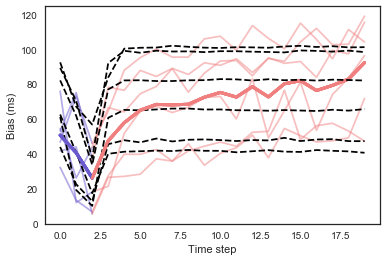

In [13]:
# Load the processed data
plotlst = [0,3,4,5,6,7]
tmax = 20
bias_all_lst = np.zeros((len(plotlst), tmax))
color1 = 'slateblue'
color2 = 'lightcoral'

for id, i in enumerate(plotlst):
    filename = dirlst[i]
    print(filename)
    bias_arr = find_bias_arr(filename, tmax)
    bias = np.sqrt(np.nanmean(bias_arr**2, axis=1)) * 1000
    
    bias_all_lst[id,:] = bias
    plt.plot(bias[:3], color1, alpha=0.5)
    plt.plot(range(2,20), bias[2:], color2, alpha=0.5)
    

# Find individual subject fit
Bias_sim_mean = []

for id in range(len(Isummary)):
    Ival = Isummary[id]
    Kval = Ksummary[id]
    alphaval = alphasummary[id]
    bias_sim_mean, bias_sim_std, _, _ = simulate_sync_cont_bias(ntrials=1000, sigma=0.01, K=Kval, initI=Ival, alpha=alphaval)

    plt.plot(np.nanmean(bias_all_lst,axis=0)[:3], color1, linewidth=3)
    plt.plot(range(2,20), np.nanmean(bias_all_lst,axis=0)[2:], color2, linewidth=3)
    plt.plot(bias_sim_mean, 'k--')
    Bias_sim_mean.append(bias_sim_mean)
plt.xlabel('Time step')
plt.ylabel('Bias (ms)')

In [14]:
#scipy.io.savemat('PlotTools/sync_cont_subject_fit_021619.mat', {'Bias_sim_mean': Bias_sim_mean, 
#                                                            'bias_sim_mean': bias_sim_mean,
#                                                               'Isummary': Isummary,
#                                                               'Ksummary': Ksummary,
#                                                               'alphasummary': alphasummary})


In [15]:
def plot_subject_ts_tp(filename):
    bias_arr = find_bias_arr(filename, 20)
    std_arr = find_std_arr(filename, 20)

    # Plot ts-tp dependence (subject)
    bias_first = bias_arr[0,:]
    std_first = std_arr[0,:]
    bias_third = bias_arr[2,:]
    std_third = std_arr[2,:]
    bias_fifth = bias_arr[4,:]
    std_fifth = std_arr[4,:]

    plt.errorbar(durs, durs + bias_third, std_third)
    plt.errorbar(durs, durs + bias_fifth, std_fifth)
    plt.plot(durs, durs, '--')
    
    
def plot_model_ts_tp(Ival, Kval, alphaval, sigmaval):
    _, _, meanITI, std_arr_sim = simulate_sync_cont_bias(ntrials=100, sigma=sigmaval, K=Kval, initI=Ival, alpha=alphaval)
    
    
    # Plot ts-tp dependence (model)
    bias_first_sim = meanITI[:,0]/1000 - durs
    std_first_sim = std_arr_sim[:,0] / 1000
    bias_third_sim = meanITI[:,2]/1000 - durs
    std_third_sim = std_arr_sim[:,2] / 1000
    bias_fifth_sim = meanITI[:,4]/1000 - durs
    std_fifth_sim = std_arr_sim[:,4] / 1000

    plt.errorbar(durs, durs + bias_third_sim, std_third_sim)
    plt.errorbar(durs, durs + bias_fifth_sim, std_fifth_sim)
    plt.plot(durs, durs, '--')

In [16]:
Bias_sim_mean = np.array(Bias_sim_mean)
_, _, meanITI, std_arr_sim = simulate_sync_cont_bias(ntrials=100, sigma=0.01, K=Ksummary[0], initI=Isummary[0],
                                                     alpha=alphasummary[0])

Plotting of observed and model ISI/IPI relationship 

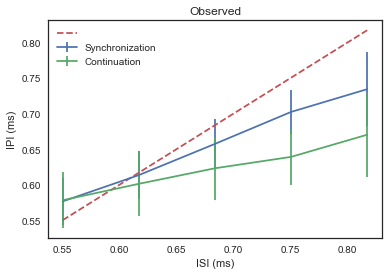

In [17]:
plot_subject_ts_tp('SyncContData\\AL_2_20170719_SynCon_ITIs.mat')
plt.title('Observed')
plt.xlabel('ISI (ms)')
plt.ylabel('IPI (ms)')
plt.legend(['', 'Synchronization', 'Continuation'])

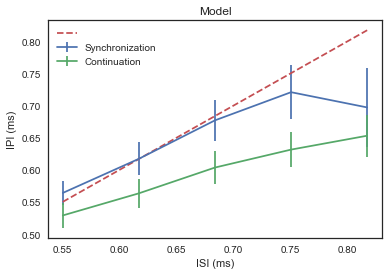

In [18]:
plot_model_ts_tp(Ival=Isummary[0], Kval=Ksummary[0], alphaval=alphasummary[0], sigmaval=0.01)
plt.title('Model')
plt.xlabel('ISI (ms)')
plt.ylabel('IPI (ms)')
plt.legend(['', 'Synchronization', 'Continuation'])

Finally, we save results of subject/model ts-tp relationship

In [19]:
filenames = []
bias_arr_all = []
std_arr_all = []
meanITI_model = []
stdITI_model = []

for i in range(6):
    # Subject info
    filename = dirlst[plotlst[i]]
    filenames.append(filename)

    bias_arr = find_bias_arr(filename, 20)
    std_arr = find_std_arr(filename, 20)
    
    bias_arr_all.append(bias_arr)
    std_arr_all.append(std_arr)
    
    # Model info
    _, _, meanITI, std_arr_sim = simulate_sync_cont_bias(ntrials=100, sigma=0.01, K=Ksummary[i], 
                                                         initI=Isummary[i], alpha=alphasummary[i])
    meanITI_model.append(meanITI)
    stdITI_model.append(std_arr_sim)
    
bias_arr_all = np.array(bias_arr_all)
std_arr_all = np.array(std_arr_all)
meanITI_model = np.array(meanITI_model)
stdITI_model = np.array(stdITI_model)

In [20]:
#scipy.io.savemat('PlotTools/subject_ts_tp_sync_cont_021619.mat', {'filenames': filenames,
#                                                                 'bias_arr_all': bias_arr_all,
#                                                                 'std_arr_all': std_arr_all,
#                                                                 'durs': durs,
#                                                                 'meanITI_model': meanITI_model,
#                                                                 'stdITI_model': stdITI_model})